# Introduction - Structure Prediction with Protein Language Models

This notebook is adapted from the [ESMFold tutorial notebook](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/ESMFold.ipynb#scrollTo=HGFBl0QYYQpR).

[ESMFold](https://www.science.org/doi/10.1126/science.ade2574) is a protein sequence-to-structure model that has been used to predict the structures of over [617 million proteins](https://esmatlas.com/) from diverse organisms. A sequence is first passed to a pretrained transformer-based protein language model, which outputs an embedding. This embedding is then passed to the folding trunk of the model to regress 3D atomic coordinates for each residue in the input sequence. The use of a protein language leverages information present in the over 65 million sequences the model was pretrained on, while reducing the inference-time costs of doing multiple sequence alignments.

In this problem, you will run ESMFold on a small protein and answer a few questions. 

# Setup


You will need a GPU to run the model. Go to **Runtime -> Change runtime type** and select **GPU** under **hardware accelerator**.


Then, run the following cell to download the model. Please note that this may take a while (>5 minutes).

In [ ]:
%%time
#@title Setup
#@markdown Install ESMFold, OpenFold and download parameters

import os, time
if not os.path.isfile("esmfold.model"):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

  # install libs
  os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol")
  os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

  # install openfold
  commit = "6908936b68ae89f67755240e2f588c09ec31d4c8"
  os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit}")

  # install esmfold
  os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")

  # wait for Params to finish downloading...
  if not os.path.isfile("esmfold.model"):
    # backup source!
    os.system("aria2c -q -x 16 https://files.ipd.uw.edu/pub/esmfold/esmfold.model")
  else:
    while os.path.isfile("esmfold.model.aria2"):
      time.sleep(5)

CPU times: user 733 ms, sys: 114 ms, total: 848 ms
Wall time: 3min 18s


# Predicting a Structure

In their [2009 paper](https://www.pnas.org/doi/pdf/10.1073/pnas.0906408106), Alexander et al. design pairs of protein sequences that that differ in as little as one residue, yet adopt different structures and functions. In particular, one protein of a pair (GA), consisting of 3 alpha helices, binds the blood transport protein albumin, while the other protein (GB), consisting of 4 beta sheets and 1 alpha helix, binds the antibody IgG.

The sequence of protein GA98 is:

TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTLKDEIKTFTVTE 

**Run the following cell on this sequence, visualize the result, and answer the question that follows. When printing this notebook a PDF, please make sure the predicted structure in the "Visualize" cell is visible.**

In [ ]:
#@title ##Run ESMFold
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]
  
  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test"
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "TTYKLILNLKQAKEEAIKELVDAGTAEKYFKLIANAKTVEGVWTLKDEIKTFTVTE" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 
chain_linker = 25 

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir():
  import torch
  model = torch.load("esmfold.model")
  model.eval().cuda().requires_grad_(False)

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
OA = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",OA["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 56
ptm: 0.595 plddt: 74.713
CPU times: user 7.94 s, sys: 7.81 s, total: 15.7 s
Wall time: 42.7 s


In [ ]:
#@title ##Visualize {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):
  
  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The following cell outputs additional information about the model's predictions. You can read more about these metrics [here](https://www.rbvi.ucsf.edu/chimerax/data/pae-apr2022/pae.html). As a summary,
* lDDT is a measure of the error between the predicted and true structures. *Predicted* lDDT is the model's prediction of this error, and is thus a measure of its confidence in its prediction. Higher numbers indicate greater confidence.
* The predicted aligned error is another measure of how confident the model is in its prediction at each residue position. Lower numbers indicate greater confidence.
* In the contacts map, cell (i, j) represents the likelihood that residue i and residue j are in close contact in 3D space.

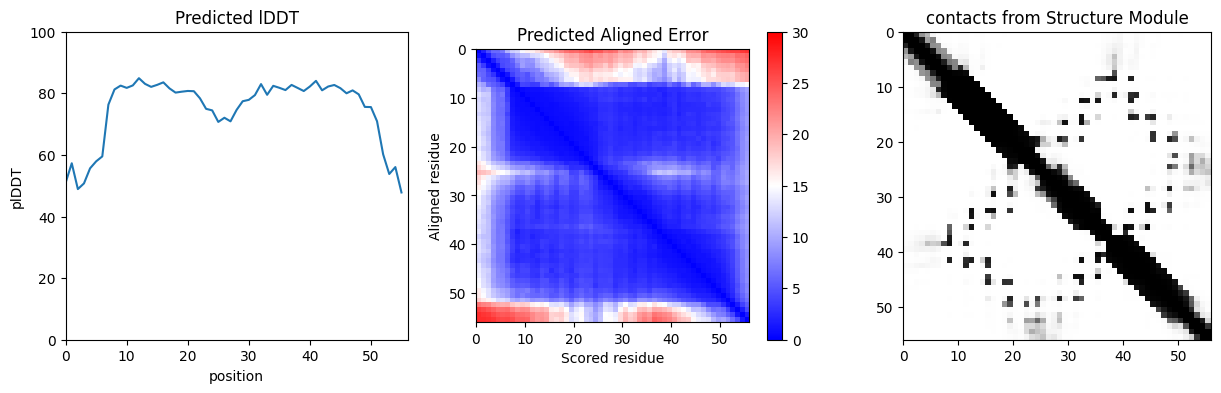

In [ ]:
#@title Plot confidence

dpi = 100

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(OA, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

**(A) Does ESMFold correctly predict the structure of GA98 as having 3 alpha helices?** Yes, the output model of GA98 correctly shows 3 alpha helices.

# Making a Mutation

GB98 differs from the sequence of GA98 above in exactly one position. Namely, the leucine at position 45 is mutated to a tyrosine (L45Y). **Run the prediction again after making this single residue change. Then, answer the questions that follow.**

In [ ]:
#@title ##Run ESMFold
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]
  
  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "test"
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = "TTYKLILNLKQAKEEAIKELVDAGTAEKYFKTIANAKTVEGVWTTKDEIKTFTVTE" #@param {type:"string"}
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3 
chain_linker = 25 

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir():
  import torch
  model = torch.load("esmfold.model")
  model.eval().cuda().requires_grad_(False)

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
OB = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",OB["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 56
ptm: 0.205 plddt: 47.060
CPU times: user 7.57 s, sys: 7.52 s, total: 15.1 s
Wall time: 48.4 s


In [ ]:
#@title ##Display {run: "auto"}
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):
  
  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "rainbow" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

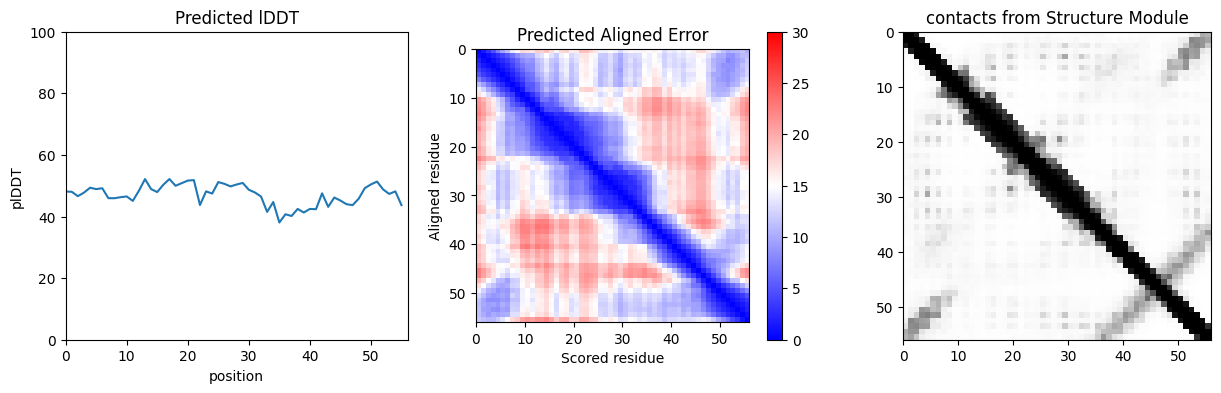

In [ ]:
#@title Plot confidence

dpi = 100

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(OB, Ls=lengths, dpi=dpi)
plt.savefig(f'{prefix}.png',bbox_inches='tight')
plt.show()

**(B) Does ESMFold correctly predict the structure of GB98 as having 4 beta sheets and 1 alpha helix? Compared to its prediction of GA98, is the model as confident in its prediction of GB98 based on the predicted lDDT?**

**No**, ESMFold predicts 2 beta sheets and 2 adjacent alpha helices. Compared to its prediction of GA98, the model is **not as confident** in its prediction of GB98 based on pIDDT. Its confidence in predicting GB98 structure fluctuates between 40 to 50 pIDDT, much lower than its pIDDT in predicting GA98 structure, which ranges between 75 to 80 for the majority of relevant positions (i.e. besides the edge positions).

**(C) It is remarkable that a single residue change can result in a significantly different structure. Propose why the mutation from leucine to tyrosine led to a structural change. You may find this [amino acid chart ](https://i2.wp.com/cms.jackwestin.com/wp-content/uploads/2020/02/Amino-acid-chart.png?resize=836%2C840&ssl=1)useful.** 

A mutation from leucine to tyrosine may have led to such a drastic structural change because the chemical properties of these two amino acids are quite different. Leucine is a nonpolar amino acid with aliphatic side chains, while tyrosine is a nonpolar amino acid with aromatic side chains. Consequently, leucine may form hydrophobic interactions with other aliphatic residues, whereas tyrosine will participate in pi-stacking interactions with other aromatic residues to affect protein folding and stability. These chemical properties influence their interactions with other amino acids and with the protein environment, leading to differences in the protein's secondary structure. 

# Long-range Contacts

One way to analyze how the mutation affects the 3D folding of the protein is to examine long-range contacts. We define a long-range contact to be two residues that are in close contact in space (i.e. probability(contact) > `threshold`) but $\geq$24 residues away apart in the sequence. We have extracted the contact matrices for GA98 and GB98 (in the variables contact_GA98 and contact_GB98). 

**Fill in the function below to count the number of long-range contacts.**

In [ ]:
'''
Arguments:
- contacts (np.array): A matrix in which element (i,j) is the likelihood 
                       of a close contact between residue i and residue j
- threshold (float): The likelihood above which we consider a pair of residues 
                     to be in close contact

Returns:
- numLongContacts (int): The number of residue pairs that are at least 24
                         residues apart and have a close contact likehood above
                         the threshold  
'''
def numContacts(contacts, threshold=0.5):

  long_range_min_dist = 24
  
  numLongContacts = 0
  for i in range(len(contacts)):
    for j in range(len(contacts)):
       ## TODO ##
       if contacts[i][j] >= threshold:
            numLongContacts += 1
  numLongContacts /= 2

  return numLongContacts

In [ ]:
contact_GA98, contact_GB98 = OA['sm_contacts'], OB['sm_contacts']
numContacts_GA98 = numContacts(contact_GA98)
numContacts_GB98 = numContacts(contact_GB98)
print(numContacts_GA98, numContacts_GB98)

259.0 194.0


**(D) How many long-range contacts are in there in the predicted structures of GA98 and GB98 at a likelihood threshold of 0.5?** 

At a likelihood threshold of 0.5, there are **259** long-range contacts in the predicted structures of GA98 and **194** long-range contacts in the predicted structures of GA98.